
Monitoring ocean health at Great Barrier Reef...
Predictive model has been trained.


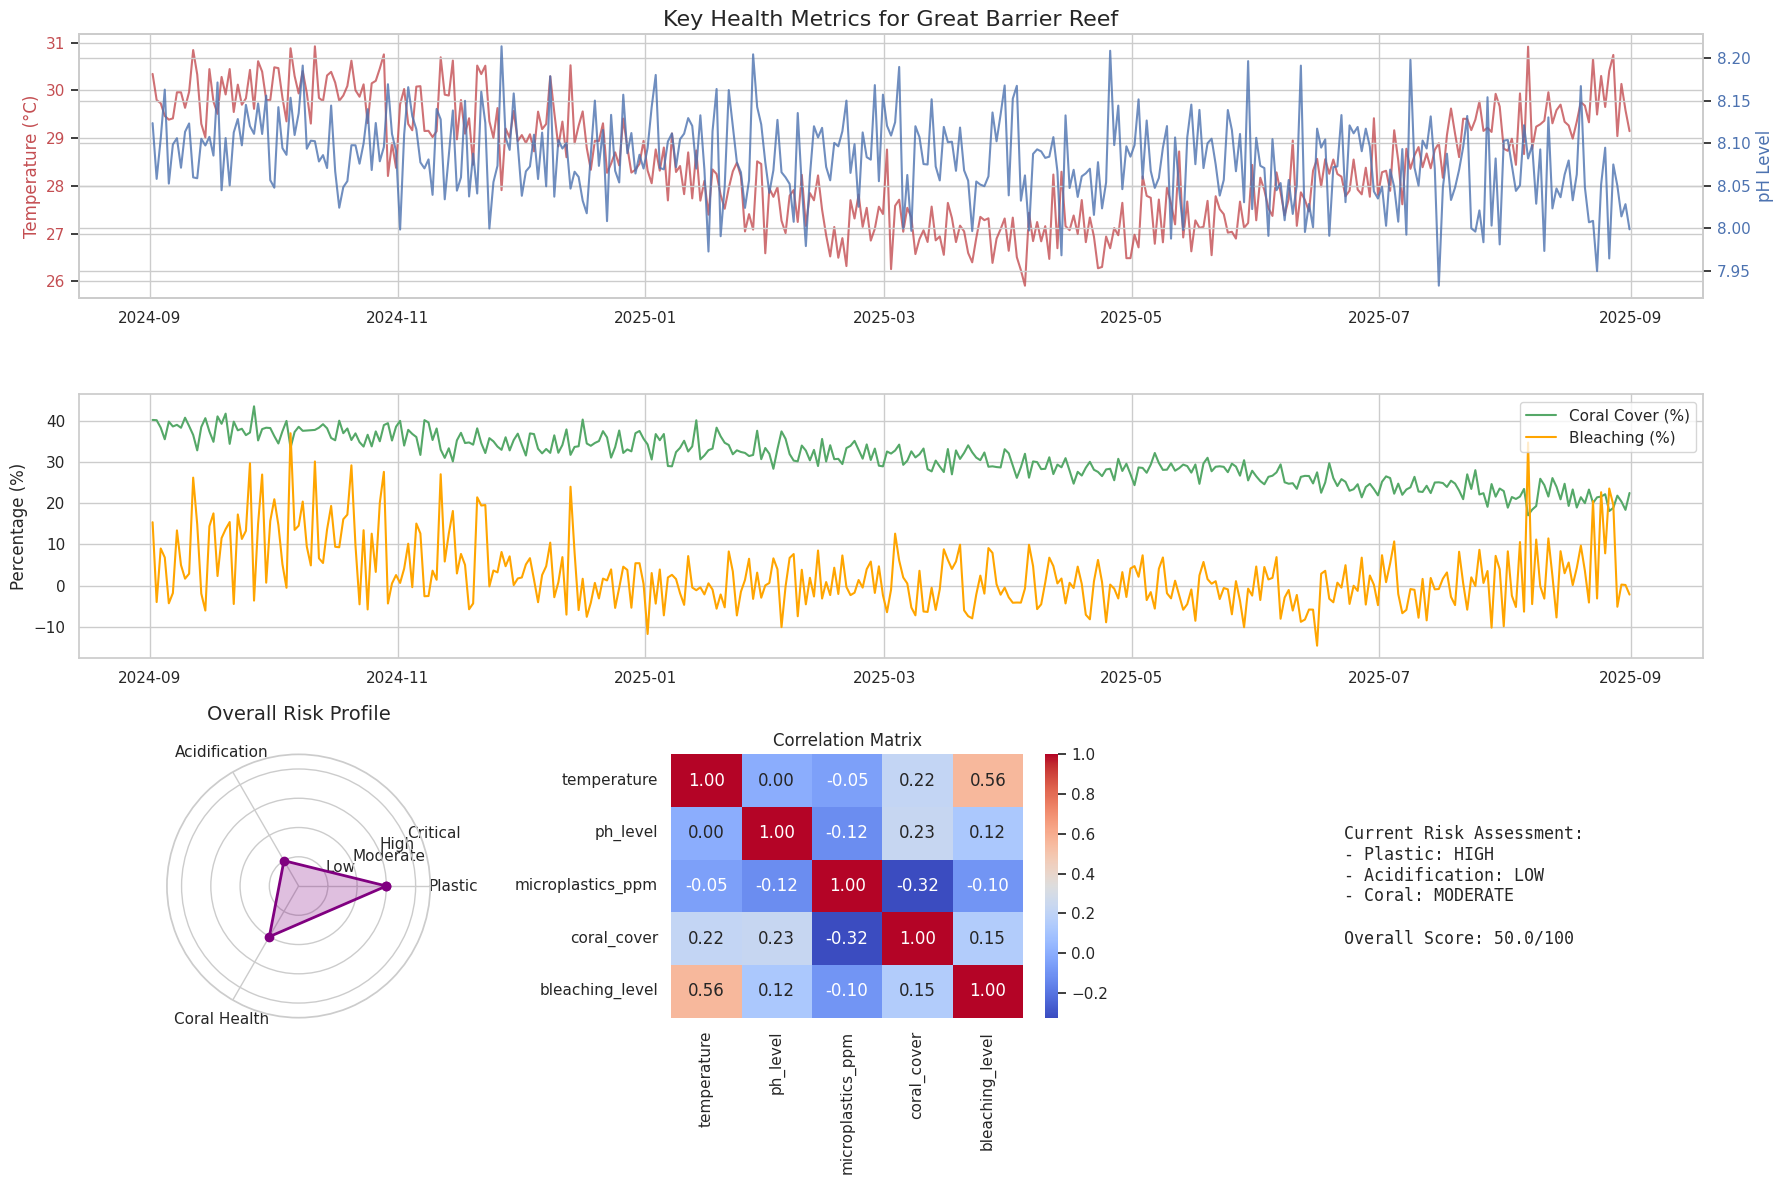


--- FINAL REPORT: Great Barrier Reef ---
  Overall Risk Score: 50.0/100
  Plastic Pollution Risk: HIGH
  Ocean Acidification Risk: LOW
  Coral Health Risk: MODERATE
  Predicted Coral Cover (30 days): 39.8%

  Recommendations:
    - High Priority: Implement plastic pollution reduction measures.
    - Prediction: Coral cover may change to ~39.8% in 30 days.
--------------------------------------------------

Monitoring ocean health at US Virgin Islands...
Predictive model has been trained.


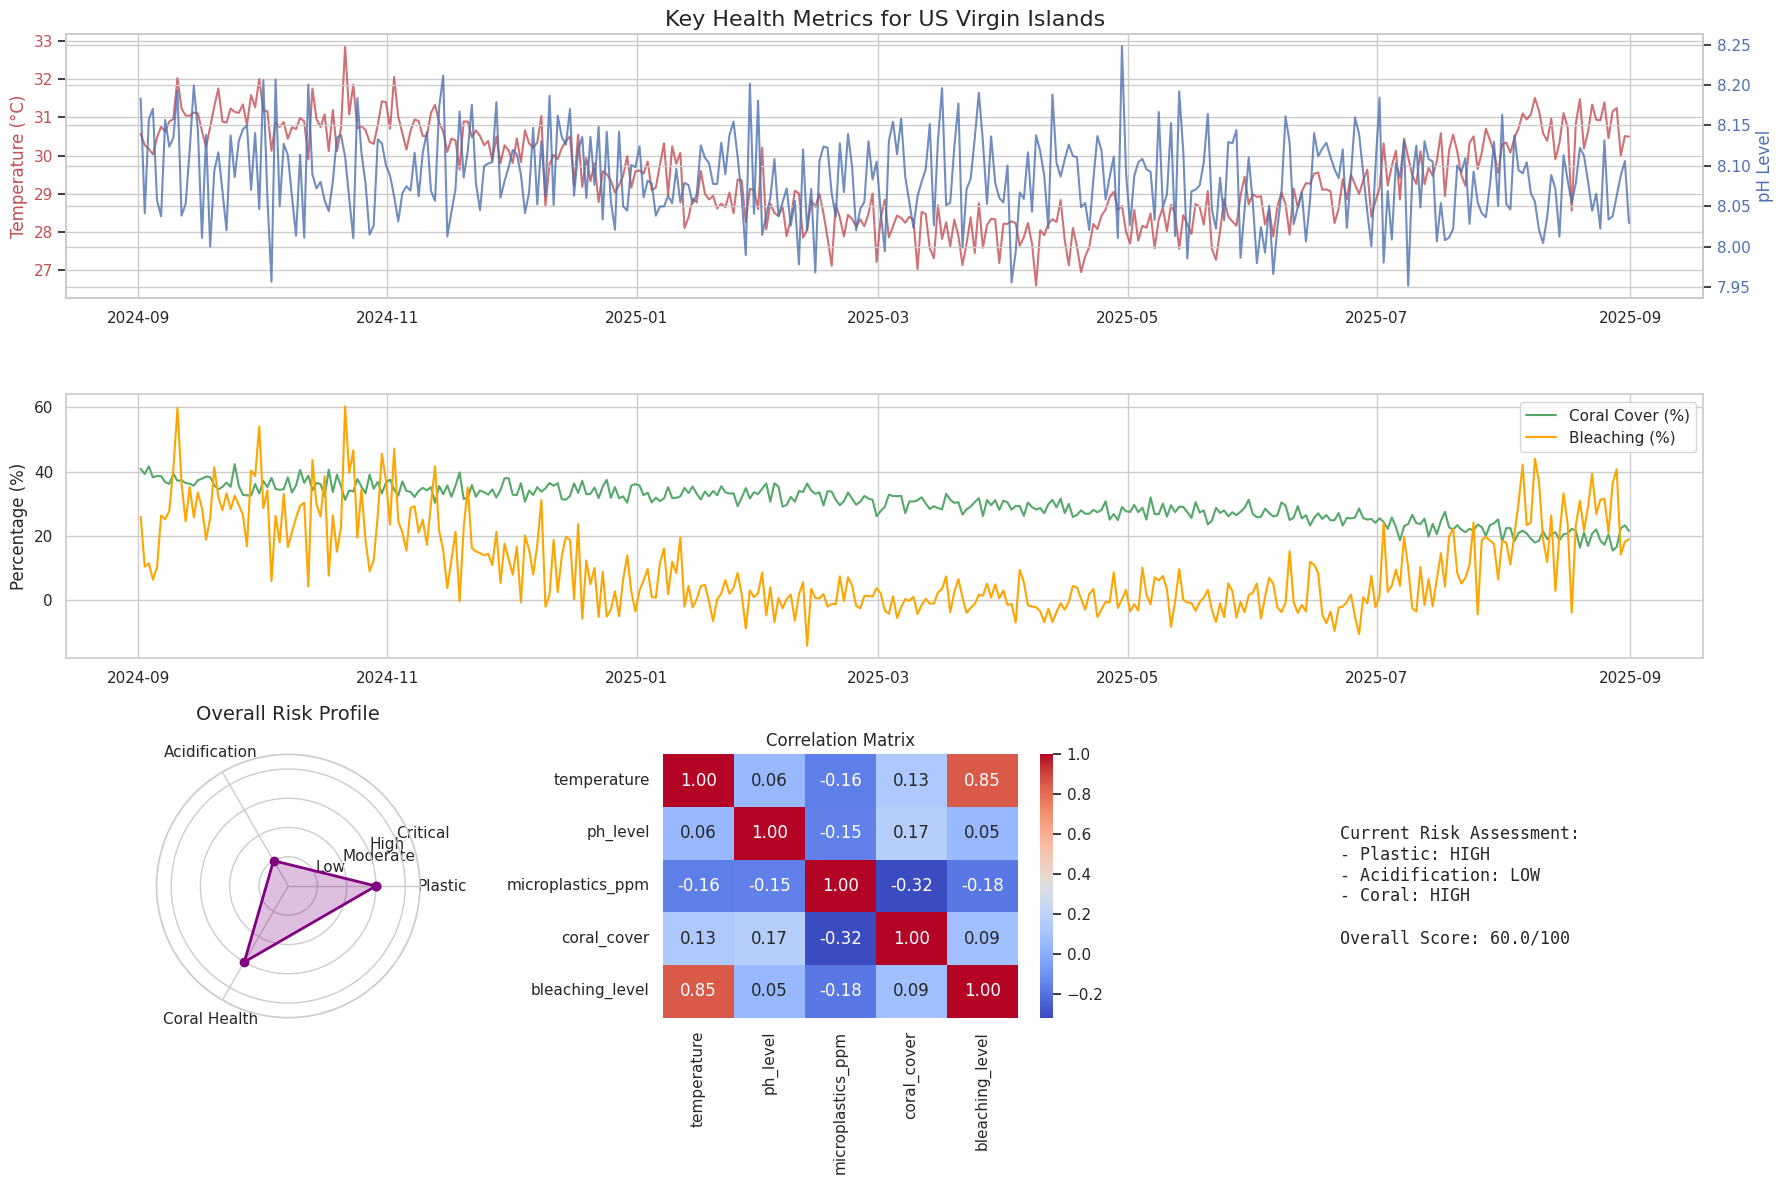


--- FINAL REPORT: US Virgin Islands ---
  Overall Risk Score: 60.0/100
  Plastic Pollution Risk: HIGH
  Ocean Acidification Risk: LOW
  Coral Health Risk: HIGH
  Predicted Coral Cover (30 days): 35.5%

  Recommendations:
    - High Priority: Implement plastic pollution reduction measures.
    - High Priority: Implement temporary fishing restrictions and consider coral restoration.
    - Prediction: Coral cover may change to ~35.5% in 30 days.
--------------------------------------------------

Monitoring ocean health at Singapore Strait...
Predictive model has been trained.


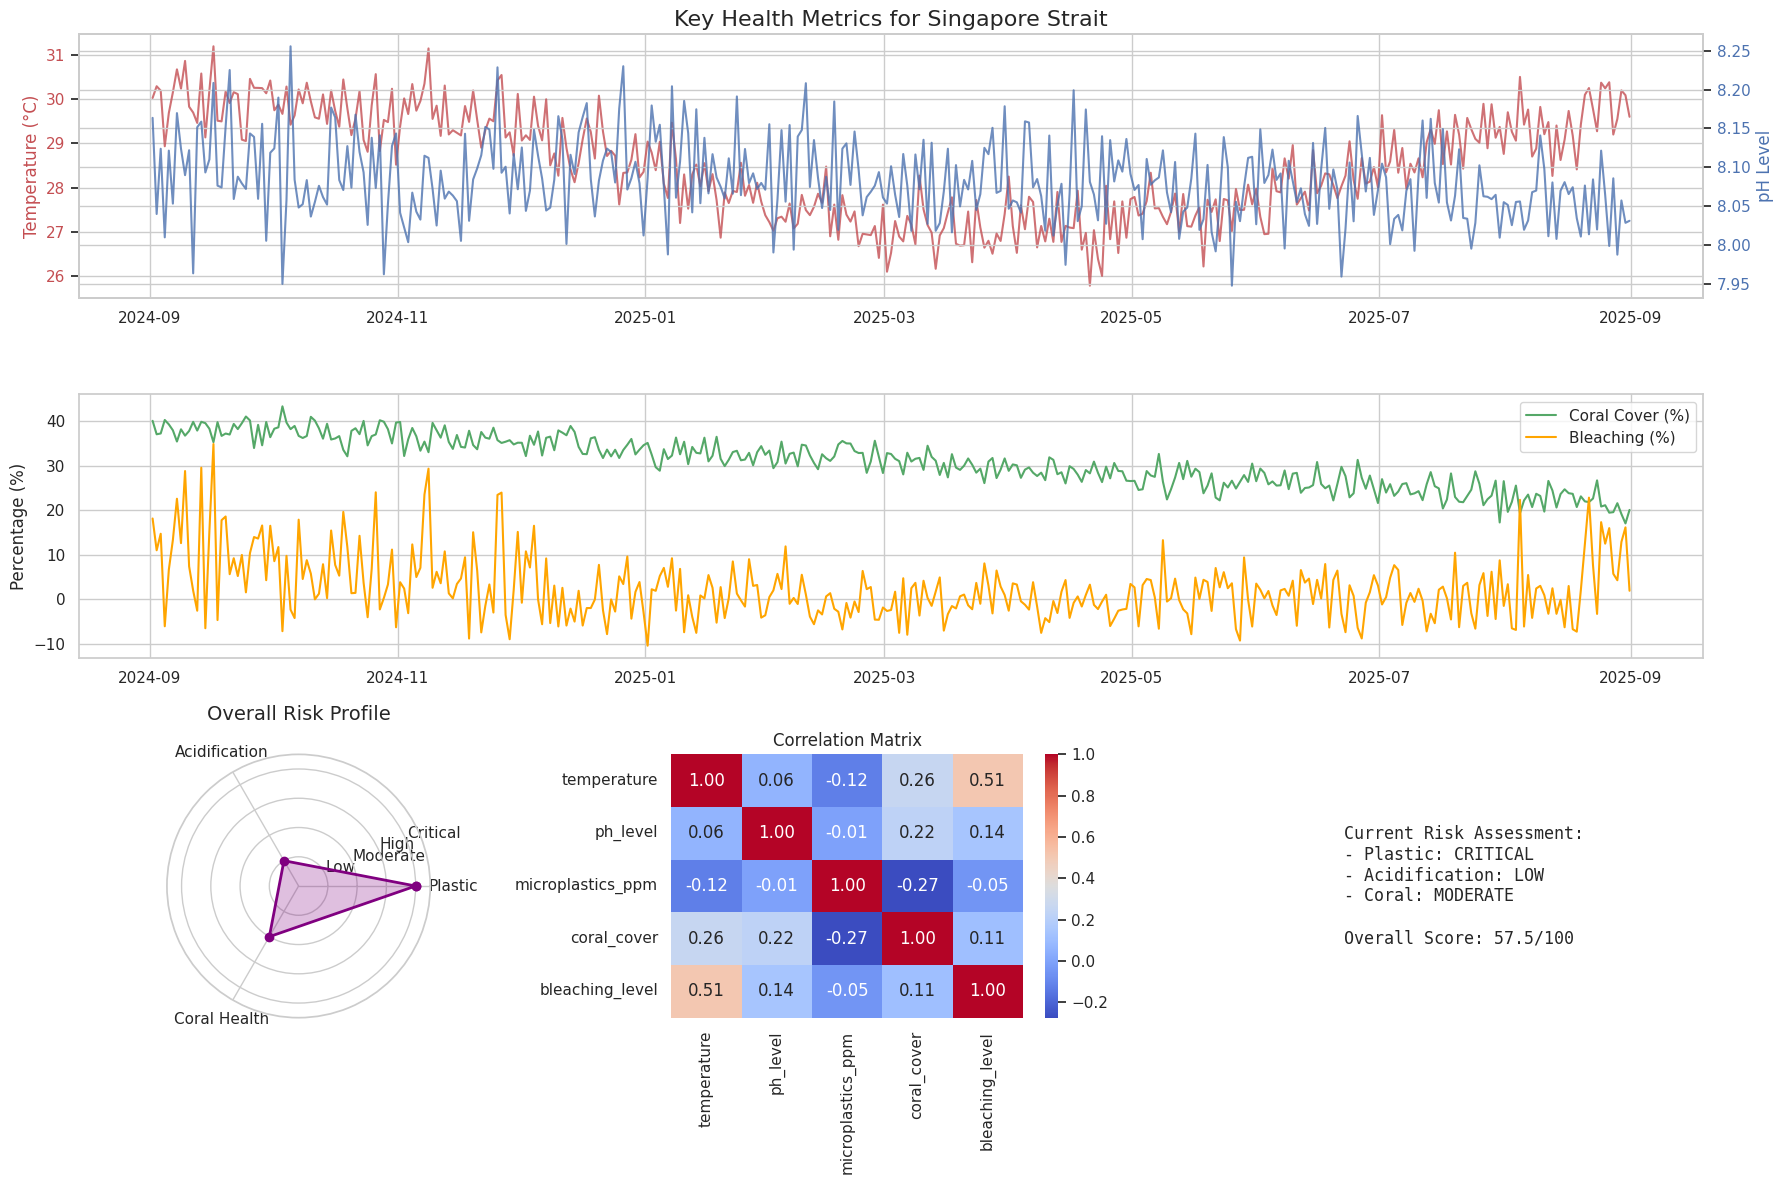


--- FINAL REPORT: Singapore Strait ---
  Overall Risk Score: 57.5/100
  Plastic Pollution Risk: CRITICAL
  Ocean Acidification Risk: LOW
  Coral Health Risk: MODERATE
  Predicted Coral Cover (30 days): 38.3%

  Recommendations:
    - High Priority: Implement plastic pollution reduction measures.
    - Prediction: Coral cover may change to ~38.3% in 30 days.
--------------------------------------------------


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from typing import Dict, List, Tuple, Optional
from dataclasses import dataclass, asdict
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings

# Suppress warnings for a cleaner output
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")

# --- Data Classes for Structuring Information ---

@dataclass(eq=True)
class Location:
    """Represents a geographical location for monitoring."""
    latitude: float
    longitude: float
    name: str
    region: str

@dataclass
class PlasticMeasurement:
    """Represents a single measurement of plastic pollution."""
    location: Location
    timestamp: datetime
    microplastics_ppm: float
    macroplastics_count: int
    source: str

@dataclass
class AcidificationMeasurement:
    """Represents a single measurement of ocean acidification."""
    location: Location
    timestamp: datetime
    ph_level: float
    dissolved_co2: float
    aragonite_saturation: float

@dataclass
class CoralHealthMeasurement:
    """Represents a single measurement of coral reef health."""
    location: Location
    timestamp: datetime
    bleaching_level: float
    coral_cover: float
    temperature: float
    alert_level: str

@dataclass
class OceanHealthReport:
    """Represents a comprehensive health report for a location."""
    location: Location
    timestamp: datetime
    plastic_risk: str
    acidification_risk: str
    coral_health_risk: str
    overall_risk_score: float
    predicted_coral_cover_30_days: Optional[float]
    recommendations: List[str]

# --- Mock Data Connectors (Simulating real-world data sources) ---

class SatelliteDataConnector:
    """Simulates fetching plastic and sea surface temperature (SST) data from satellites."""
    def __init__(self, api_key: str = None):
        self.api_key = api_key
        # In a real scenario, these would be used with a library like 'requests'
        self.plastic_detection_url = "https://api.satelliteimagery.com/plastic"
        self.sst_url = "https://api.satelliteimagery.com/sst"

    def get_plastic_data(self, location: Location, date_range: Tuple[datetime, datetime]) -> List[PlasticMeasurement]:
        """Generates simulated plastic pollution data."""
        days = (date_range[1] - date_range[0]).days
        measurements = []
        for i in range(days):
            current_date = date_range[0] + timedelta(days=i)
            # Simulate higher pollution in certain regions
            base_value = 150 if location.region == "Southeast Asia" else 80
            microplastics = max(10, np.random.normal(base_value, 30) + i * 0.1) # Slight upward trend
            macroplastics = max(5, int(np.random.normal(base_value / 10, 15)))
            measurements.append(PlasticMeasurement(
                location=location,
                timestamp=current_date,
                microplastics_ppm=microplastics,
                macroplastics_count=macroplastics,
                source="satellite"
            ))
        return measurements

    def get_sst_data(self, location: Location, date_range: Tuple[datetime, datetime]) -> List[float]:
        """Generates simulated Sea Surface Temperature (SST) data with seasonality."""
        days = (date_range[1] - date_range[0]).days
        start_date = date_range[0]
        base_temp = 28.5
        # Set base temperatures for different climate zones
        if location.region == "Caribbean":
            base_temp = 29.5
        elif location.region == "Arctic":
            base_temp = 3.5

        temperatures = []
        for i in range(days):
            current_date = start_date + timedelta(days=i)
            # Add a sine wave for seasonality
            seasonal_variation = 1.5 * np.sin(2 * np.pi * (current_date.timetuple().tm_yday / 365.25 - 0.5))
            daily_noise = np.random.normal(0, 0.5)
            temperatures.append(base_temp + seasonal_variation + daily_noise)
        return temperatures


class SensorNetworkConnector:
    """Simulates fetching data from underwater sensor networks."""
    def get_acidification_data(self, location: Location, date_range: Tuple[datetime, datetime]) -> List[AcidificationMeasurement]:
        """Generates simulated ocean acidification data."""
        days = (date_range[1] - date_range[0]).days
        measurements = []
        for i in range(days):
            current_date = date_range[0] + timedelta(days=i)
            # Simulate a gradual decline in pH over time
            base_ph = 8.1 - (0.0001 * i)
            ph_level = max(7.7, min(8.3, np.random.normal(base_ph, 0.05)))
            dissolved_co2 = 400 + (i * 0.05) + np.random.normal(0, 10) # Using more realistic ppm values
            aragonite_saturation = 3.5 - (0.001 * i) + np.random.normal(0, 0.2)
            measurements.append(AcidificationMeasurement(
                location=location,
                timestamp=current_date,
                ph_level=ph_level,
                dissolved_co2=dissolved_co2,
                aragonite_saturation=aragonite_saturation
            ))
        return measurements


class DroneSurveyConnector:
    """Simulates collecting coral health data via autonomous drones."""
    def get_coral_data(self, location: Location, date_range: Tuple[datetime, datetime]) -> List[CoralHealthMeasurement]:
        """Generates simulated coral health data based on temperature."""
        days = (date_range[1] - date_range[0]).days
        measurements = []
        sst_data = SatelliteDataConnector().get_sst_data(location, date_range)
        for i in range(days):
            current_date = date_range[0] + timedelta(days=i)
            temperature = sst_data[i]
            # Bleaching increases significantly with higher temperatures
            bleaching_base = max(0, (temperature - 29.5) * 20)
            bleaching_level = min(95, bleaching_base + np.random.normal(0, 5))
            # Coral cover slowly degrades with stress
            coral_cover = max(5, 40 - (i * 0.05) - (bleaching_level * 0.1) + np.random.normal(0, 2))

            # Determine alert level based on temperature and bleaching
            if temperature > 30.5 or bleaching_level > 50:
                alert_level = "Alert Level 2 (Severe Bleaching)"
            elif temperature > 29.8 or bleaching_level > 30:
                alert_level = "Alert Level 1 (Bleaching Likely)"
            elif temperature > 29.0 or bleaching_level > 15:
                alert_level = "Warning (Bleaching Possible)"
            else:
                alert_level = "No Stress"

            measurements.append(CoralHealthMeasurement(
                location=location,
                timestamp=current_date,
                bleaching_level=bleaching_level,
                coral_cover=coral_cover,
                temperature=temperature,
                alert_level=alert_level
            ))
        return measurements

# --- Analysis and Prediction Modules ---

class RiskAssessor:
    """Calculates risk levels based on provided data."""
    RISK_LEVELS = {"low": 1, "moderate": 2, "high": 3, "critical": 4}

    @staticmethod
    def assess_plastic_risk(plastic_data: List[PlasticMeasurement]) -> str:
        """Assesses plastic risk based on recent microplastic levels."""
        if not plastic_data: return "low"
        recent_data = plastic_data[-30:]
        avg_microplastics = np.mean([m.microplastics_ppm for m in recent_data])
        if avg_microplastics > 150: return "critical"
        if avg_microplastics > 90: return "high"
        if avg_microplastics > 40: return "moderate"
        return "low"

    @staticmethod
    def assess_acidification_risk(acid_data: List[AcidificationMeasurement]) -> str:
        """Assesses acidification risk based on recent pH and aragonite levels."""
        if not acid_data: return "low"
        recent_data = acid_data[-30:]
        avg_ph = np.mean([m.ph_level for m in recent_data])
        avg_aragonite = np.mean([m.aragonite_saturation for m in recent_data])
        if avg_ph < 7.8 or avg_aragonite < 2.0: return "critical"
        if avg_ph < 7.9 or avg_aragonite < 2.5: return "high"
        if avg_ph < 8.0 or avg_aragonite < 3.0: return "moderate"
        return "low"

    @staticmethod
    def assess_coral_risk(coral_data: List[CoralHealthMeasurement]) -> str:
        """Assesses coral health risk based on recent bleaching and cover."""
        if not coral_data: return "low"
        recent_data = coral_data[-30:]
        avg_bleaching = np.mean([m.bleaching_level for m in recent_data])
        avg_cover = np.mean([m.coral_cover for m in recent_data])
        if avg_bleaching > 50 or avg_cover < 10: return "critical"
        if avg_bleaching > 30 or avg_cover < 20: return "high"
        if avg_bleaching > 15 or avg_cover < 30: return "moderate"
        return "low"

    def calculate_overall_risk(self, plastic_risk: str, acidification_risk: str, coral_risk: str) -> Tuple[float, List[str]]:
        """Calculates a weighted overall risk score and provides recommendations."""
        plastic_score = self.RISK_LEVELS[plastic_risk]
        acid_score = self.RISK_LEVELS[acidification_risk]
        coral_score = self.RISK_LEVELS[coral_risk]

        # Weighted average for overall score (0-100 scale)
        overall_score = (plastic_score * 0.3 + acid_score * 0.3 + coral_score * 0.4) * 25

        recommendations = []
        if plastic_score >= 3:
            recommendations.append("High Priority: Implement plastic pollution reduction measures.")
        if acid_score >= 3:
            recommendations.append("High Priority: Reduce local CO2 emissions impacting coastal waters.")
        if coral_score >= 3:
            recommendations.append("High Priority: Implement temporary fishing restrictions and consider coral restoration.")
        if not recommendations:
            recommendations.append("Continue current conservation and monitoring efforts.")

        return min(100, overall_score), recommendations


class PredictiveModel:
    """A predictive model for forecasting coral health."""
    def __init__(self):
        self.model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        self.scaler = StandardScaler()
        self.is_trained = False
        self.features = [
            'temperature', 'ph_level', 'microplastics_ppm', 'dissolved_co2',
            'bleaching_level', 'day_of_year'
        ]

    def train(self, historical_data: pd.DataFrame):
        """Trains the Random Forest model on historical data."""
        if historical_data.empty:
            print("Warning: No historical data to train the model.")
            return

        X = historical_data[self.features].copy()
        y = historical_data['coral_cover'].values

        # Scale the features
        X_scaled = self.scaler.fit_transform(X)

        # Train the model
        self.model.fit(X_scaled, y)
        self.is_trained = True
        print("Predictive model has been trained.")

    def predict_coral_health(self, current_conditions: pd.DataFrame) -> Optional[float]:
        """Predicts coral cover for the next 30 days."""
        if not self.is_trained:
            print("Warning: Model is not trained. Cannot make predictions.")
            return None

        future_conditions = current_conditions[self.features].copy()

        # Simulate conditions 30 days from now (e.g., increased temperature)
        future_conditions['temperature'] += 0.2
        future_conditions['day_of_year'] = (future_conditions['day_of_year'] + 30) % 365

        features_scaled = self.scaler.transform(future_conditions)
        return self.model.predict(features_scaled)[0]

# --- Visualization Module ---

class OceanHealthVisualizer:
    """Handles the creation of plots and charts."""
    @staticmethod
    def plot_risk_dashboard(df: pd.DataFrame, risk_assessment: Dict):
        """Creates and displays a dashboard of key metrics and a risk radar chart."""
        fig = plt.figure(figsize=(18, 12))
        gs = fig.add_gridspec(3, 3)

        # Main timeline plots
        ax1 = fig.add_subplot(gs[0, :])
        ax1.plot(df['timestamp'], df['temperature'], 'r-', label='Temperature (°C)', alpha=0.8)
        ax1.set_ylabel('Temperature (°C)', color='r')
        ax1.tick_params(axis='y', labelcolor='r')
        ax1.set_title(f'Key Health Metrics for {df["location_name"].iloc[0]}', fontsize=16)
        ax2 = ax1.twinx()
        ax2.plot(df['timestamp'], df['ph_level'], 'b-', label='pH Level', alpha=0.8)
        ax2.set_ylabel('pH Level', color='b')
        ax2.tick_params(axis='y', labelcolor='b')

        ax3 = fig.add_subplot(gs[1, :])
        ax3.plot(df['timestamp'], df['coral_cover'], 'g-', label='Coral Cover (%)')
        ax3.plot(df['timestamp'], df['bleaching_level'], 'orange', label='Bleaching (%)')
        ax3.set_ylabel('Percentage (%)')
        ax3.legend()

        # Radar Chart for Risk Assessment
        ax_radar = fig.add_subplot(gs[2, 0], polar=True)
        categories = ['Plastic', 'Acidification', 'Coral Health']
        risk_levels = RiskAssessor.RISK_LEVELS
        values = [
            risk_levels[risk_assessment['plastic_risk']],
            risk_levels[risk_assessment['acidification_risk']],
            risk_levels[risk_assessment['coral_risk']]
        ]
        angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
        values += values[:1]
        angles += angles[:1]

        ax_radar.plot(angles, values, 'o-', linewidth=2, color='purple')
        ax_radar.fill(angles, values, alpha=0.25, color='purple')
        ax_radar.set_thetagrids(np.degrees(angles[:-1]), categories)
        ax_radar.set_ylim(0, 4.5)
        ax_radar.set_title('Overall Risk Profile', size=14, y=1.1)
        ax_radar.set_yticks([1, 2, 3, 4])
        ax_radar.set_yticklabels(['Low', 'Moderate', 'High', 'Critical'])

        # Correlation Heatmap
        ax_heatmap = fig.add_subplot(gs[2, 1])
        corr = df[['temperature', 'ph_level', 'microplastics_ppm', 'coral_cover', 'bleaching_level']].corr()
        sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", ax=ax_heatmap)
        ax_heatmap.set_title('Correlation Matrix')

        # Placeholder for text report
        ax_text = fig.add_subplot(gs[2, 2])
        ax_text.axis('off')
        text_report = f"""
        Current Risk Assessment:
        - Plastic: {risk_assessment['plastic_risk'].upper()}
        - Acidification: {risk_assessment['acidification_risk'].upper()}
        - Coral: {risk_assessment['coral_risk'].upper()}

        Overall Score: {risk_assessment['overall_score']:.1f}/100
        """
        ax_text.text(0, 0.5, text_report, va='center', fontsize=12, fontfamily='monospace')

        plt.tight_layout()
        plt.show()

# --- Main Orchestration Class ---

class OceanHealthMonitoringSystem:
    """Orchestrates the data collection, analysis, prediction, and reporting."""
    def __init__(self):
        self.satellite_connector = SatelliteDataConnector()
        self.sensor_connector = SensorNetworkConnector()
        self.drone_connector = DroneSurveyConnector()
        self.risk_assessor = RiskAssessor()
        self.visualizer = OceanHealthVisualizer()
        self.predictive_model = PredictiveModel()

    def _consolidate_data(self, plastic_data: List[PlasticMeasurement], acid_data: List[AcidificationMeasurement], coral_data: List[CoralHealthMeasurement]) -> pd.DataFrame:
        """Consolidates data from different sources into a single pandas DataFrame."""
        consolidated_list = []
        # Assuming all data lists have the same length and are aligned by timestamp and location
        for i in range(len(plastic_data)):
            consolidated_list.append({
                'location': plastic_data[i].location,
                'location_name': plastic_data[i].location.name,
                'timestamp': plastic_data[i].timestamp,
                'microplastics_ppm': plastic_data[i].microplastics_ppm,
                'macroplastics_count': plastic_data[i].macroplastics_count,
                'ph_level': acid_data[i].ph_level,
                'dissolved_co2': acid_data[i].dissolved_co2,
                'aragonite_saturation': acid_data[i].aragonite_saturation,
                'bleaching_level': coral_data[i].bleaching_level,
                'coral_cover': coral_data[i].coral_cover,
                'temperature': coral_data[i].temperature,
                'alert_level': coral_data[i].alert_level
            })

        df = pd.DataFrame(consolidated_list)
        # Add useful time-based features for modeling
        df['day_of_year'] = df['timestamp'].dt.dayofyear
        return df


    def monitor_location(self, location: Location, days: int = 365) -> OceanHealthReport:
        """Runs the complete monitoring and reporting workflow for a location."""
        end_date = datetime.now()
        start_date = end_date - timedelta(days=days)
        date_range = (start_date, end_date)

        print(f"\n{'='*20}\nMonitoring ocean health at {location.name}...\n{'='*20}")

        # 1. Collect Data from all sources
        plastic_data = self.satellite_connector.get_plastic_data(location, date_range)
        acidification_data = self.sensor_connector.get_acidification_data(location, date_range)
        coral_data = self.drone_connector.get_coral_data(location, date_range)

        # 2. Consolidate data for analysis and modeling
        historical_df = self._consolidate_data(plastic_data, acidification_data, coral_data)

        # 3. Perform Risk Assessment
        plastic_risk = self.risk_assessor.assess_plastic_risk(plastic_data)
        acidification_risk = self.risk_assessor.assess_acidification_risk(acidification_data)
        coral_risk = self.risk_assessor.assess_coral_risk(coral_data)
        overall_score, recommendations = self.risk_assessor.calculate_overall_risk(
            plastic_risk, acidification_risk, coral_risk
        )

        # 4. Train the Predictive Model and Make a Forecast
        self.predictive_model.train(historical_df)
        current_conditions = historical_df.iloc[[-1]] # Get the most recent data row
        predicted_cover = self.predictive_model.predict_coral_health(current_conditions)
        if predicted_cover is not None:
             recommendations.append(f"Prediction: Coral cover may change to ~{predicted_cover:.1f}% in 30 days.")

        # 5. Generate and Display Visual Dashboard
        risk_dict = {
            'plastic_risk': plastic_risk,
            'acidification_risk': acidification_risk,
            'coral_risk': coral_risk,
            'overall_score': overall_score
        }
        self.visualizer.plot_risk_dashboard(historical_df, risk_dict)

        # 6. Compile the final report
        return OceanHealthReport(
            location=location,
            timestamp=datetime.now(),
            plastic_risk=plastic_risk,
            acidification_risk=acidification_risk,
            coral_health_risk=coral_risk,
            overall_risk_score=overall_score,
            predicted_coral_cover_30_days=predicted_cover,
            recommendations=recommendations
        )


def main():
    """Main function to run the ocean health monitoring simulation."""
    monitoring_system = OceanHealthMonitoringSystem()

    locations = [
        Location(latitude=-16.5, longitude=145.78, name="Great Barrier Reef", region="Australia"),
        Location(latitude=18.33, longitude=-64.8, name="US Virgin Islands", region="Caribbean"),
        Location(latitude=1.35, longitude=103.82, name="Singapore Strait", region="Southeast Asia"),
    ]

    for location in locations:
        report = monitoring_system.monitor_location(location, days=365)
        print(f"\n--- FINAL REPORT: {location.name} ---")
        print(f"  Overall Risk Score: {report.overall_risk_score:.1f}/100")
        print(f"  Plastic Pollution Risk: {report.plastic_risk.upper()}")
        print(f"  Ocean Acidification Risk: {report.acidification_risk.upper()}")
        print(f"  Coral Health Risk: {report.coral_health_risk.upper()}")
        if report.predicted_coral_cover_30_days is not None:
            print(f"  Predicted Coral Cover (30 days): {report.predicted_coral_cover_30_days:.1f}%")
        print("\n  Recommendations:")
        for rec in report.recommendations:
            print(f"    - {rec}")
        print("-" * 50)

if __name__ == "__main__":
    main()